# Setup

In [1]:
# mount drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd "/content/gdrive/My Drive/Github/SubjectIndexing"

/content/gdrive/My Drive/Github/SubjectIndexing


In [3]:
# general
import time
import itertools
import collections
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn models
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

# tensorflow
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# custom library for transformers
from src.utils.embeddings import Book2Vec

# Import Data

In [4]:
# import dataset
df = pd.read_json('./data/dataset_B.json')
metadata = pd.read_json('./data/metadata.json')
X_embeddings = Book2Vec.load_embeddings('./work/embeddings_B_last4layers.pkl')
df['X_embeddings'] = list(X_embeddings)
full_dataset = df.merge(metadata, left_on='id', right_on='id')[['id', 'X', 'y', 'X_embeddings', 'subjects_new']]
# dataset = full_dataset
dataset = full_dataset[full_dataset['y'].isin(['BR', 'B', 'BJ'])]

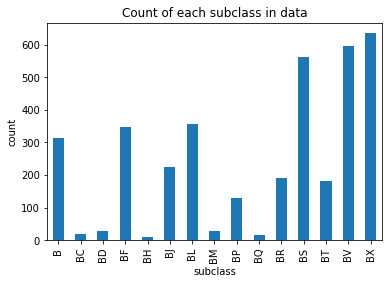

In [5]:
# show subclasses count in data
pd.value_counts(full_dataset['y']).sort_index().plot(kind="bar", title='Count of each subclass in data', xlabel='subclass', ylabel='count')

In [6]:
# remove subjects that only appeared once 
freq = collections.Counter(itertools.chain(*[x for x in dataset['subjects_new']]))
subjects_filtered = []
for row in dataset['subjects_new']:
    row_temp = []
    for c in row:
        if freq[c] != 1:
            row_temp.append(c)
    subjects_filtered.append(row_temp)
dataset['subjects_filtered'] = subjects_filtered

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
dataset[['id', 'X_embeddings', 'y', 'subjects_new', 'subjects_filtered']].head()

,id,X_embeddings,y,subjects_new,subjects_filtered
3,59,"[0.12214074, 0.06482455, 0.08797064, -0.114956...",B,"[Science, B, Methodology]","[Science, B, Methodology]"
5,130,"[0.0726224, 0.028099691, 0.11365156, -0.159741...",BR,"[Chesterton, G. K. (Gilbert Keith), 1874-1936,...","[Chesterton, G. K. (Gilbert Keith), 1874-1936,..."
8,272,"[0.061839424, 0.03096132, 0.09124701, -0.10134...",BR,"[Reformation, BR, Bible]","[Reformation, BR, Bible]"
10,274,"[0.0448586, 0.046716735, 0.09408784, -0.146873...",BR,"[BR, Reformation, Indulgences]","[BR, Reformation]"
13,368,"[0.032058243, 0.011893238, 0.055835266, -0.096...",BJ,"[Success, Temple University, BJ, Conwell, Russ...","[Success, BJ]"


In [8]:
# train test split
np.random.seed(0)
msk = np.random.rand(len(dataset)) < 0.8
dataset_train = dataset.copy()[msk]
dataset_test = dataset.copy()[~msk]

In [9]:
labels = sorted(list(set(dataset.y)))
class2label = {}
for i in range(len(labels)):
    class2label[labels[i]] = i
label2class = {v:k for k,v in class2label.items()}
y_train_labels = [class2label[l] for l in dataset_train.y]
y_test_labels = [class2label[l] for l in dataset_test.y]

# Nearest Neighbors

## Filter: Classifier

In [10]:
# filter possible subjects with SVM classifier
svm = make_pipeline(StandardScaler(), SVC(C=10, gamma='scale', random_state=0))
svm.fit(list(dataset_train.X_embeddings), y_train_labels)
TOP = 1
y_pred_top_k = np.argpartition(svm.decision_function(list(dataset_test.X_embeddings)), -TOP)[:,-TOP:]

In [11]:
# filter with top k subclass
accuracy_score_top_k = []
for i in range(len(y_test_labels)):
   ct = 1 if (y_test_labels[i] in y_pred_top_k[i]) else 0
   accuracy_score_top_k.append(ct)
print("top " + str(TOP) + " acc: " + str(round(np.mean(accuracy_score_top_k), 4)))

top 1 acc: 0.8028


## Filter: Distance

In [12]:
# find nearest neighbors
K = 5
distance_matrix = cosine_distances(list(dataset_test.X_embeddings), list(dataset_train.X_embeddings))
neighbors = np.argpartition(distance_matrix, K)[:,:K]

## Apply Filters

In [13]:
# find suggested subjects
suggested_subjects = []
for i in range(len(neighbors)):
    #suggest_temp = set(itertools.chain(*list(dataset_train.iloc[neighbors[i]]['subjects_filtered'])))
    suggest_temp = set()
    for l in y_pred_top_k[i]:
        for n in range(len(neighbors[i])):
            suggest = set(list(dataset_train.iloc[neighbors[i]]['subjects_filtered'])[n])
            if label2class[l] in suggest:
                suggest_temp.update(suggest)
    suggest_temp = set(['']) if suggest_temp == set() else suggest_temp
    suggested_subjects.append(suggest_temp)
dataset_test['subjects_suggest'] = suggested_subjects

## Evaluate Model

In [14]:
# calculate scores
mlb = MultiLabelBinarizer()
mlb.fit(dataset.subjects_filtered)
subjects_new_matrix = mlb.transform(dataset_test.subjects_filtered)
subjects_suggest_matrix = mlb.transform(dataset_test.subjects_suggest)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) [''] will be ignored
  .format(sorted(unknown, key=str)))


In [15]:
precision_recall_fscore_support(subjects_new_matrix, subjects_suggest_matrix, average='micro', zero_division=0)

(0.2648221343873518, 0.5598885793871866, 0.3595706618962433, None)

In [16]:
precision_recall_fscore_support(subjects_new_matrix, subjects_suggest_matrix, average='macro', zero_division=0)

(0.09516024398320666, 0.15955803443608324, 0.10884620170716505, None)

# Save Result

In [17]:
output = dataset_test.merge(metadata, left_on='id', right_on='id')[['title', 'creator', 'subjects_filtered', 'subjects_suggest']]
output.to_csv('test_result.csv', index=False)